#**아래의 experiment_number 꼭 입력**

In [ ]:
experiment_number = 'ConvNeXt + InceptionV3 + RGB Weights + Weighted CE' ### 자기 실험 번호 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm ptflops

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import scipy.io
import timm
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ptflops import get_model_complexity_info
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
!pip install torchprofile
from torchprofile import profile_macs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = '/content/drive/MyDrive/심층신경망개론/'

In [ ]:
seg_dir = os.path.join(data_dir, '102segmentations')

In [ ]:
setid = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))

train_ids = setid['trnid'][0]
valid_ids = setid['valid'][0]
test_ids = setid['tstid'][0]
image_labels = labels['labels'][0]

In [ ]:
def create_image_weight(seg_mask):
    seg_rgb = np.array(seg_mask)

    background = (seg_rgb[:, :, 0] == 0) & (seg_rgb[:, :, 1] == 0) & (seg_rgb[:, :, 2] == 0)

    flower_region = ~background
    flower_region = flower_region.astype(np.float32)

    flower_ratio = flower_region.mean()

    weight = 1.0 + (flower_ratio * 0.5)
    return float(weight)

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets, weights=None):
        loss = self.ce(inputs, targets)

        if weights is not None:
            loss = loss * weights

        return loss.mean()

class OxfordFlowersDataset(Dataset):
    def __init__(self, image_ids, labels, root_dir, seg_dir=None, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.seg_dir = seg_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'jpg', f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id - 1] - 1

        seg_mask = None
        if self.seg_dir is not None:
            seg_path = os.path.join(self.seg_dir, f'foreground_{img_id:05d}.png')
            if os.path.exists(seg_path):
                seg_mask = Image.open(seg_path).convert('RGB')
            else:
                w, h = image.size
                seg_mask = Image.new('RGB', (w, h), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        img_weight = 1.0
        if seg_mask is not None:
            img_weight = create_image_weight(seg_mask)

        return image, label, img_weight

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = OxfordFlowersDataset(train_ids, image_labels, data_dir, seg_dir=seg_dir, transform=train_transforms)
valid_dataset = OxfordFlowersDataset(valid_ids, image_labels, data_dir, seg_dir=seg_dir, transform=val_test_transforms)
test_dataset = OxfordFlowersDataset(test_ids, image_labels, data_dir, seg_dir=seg_dir, transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.aux_logits = False
in_features_inception = inception.fc.in_features
inception.fc = nn.Identity()

convnext = models.convnext_tiny(pretrained=True)
in_features_convnext = convnext.classifier[2].in_features
convnext.classifier[2] = nn.Identity()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception = inception.to(device)
convnext = convnext.to(device)

class CombinedModel(nn.Module):
    def __init__(self, inception, convnext, num_classes=102):
        super(CombinedModel, self).__init__()
        self.inception = inception
        self.convnext = convnext
        self.fc1 = nn.Linear(in_features_inception + in_features_convnext, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.745093574409461)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        f1 = self.inception(x)
        f2 = self.convnext(x)
        f = torch.cat([f1, f2], dim=1)
        f = self.fc1(f)
        f = self.bn1(f)
        f = self.relu(f)
        f = self.dropout(f)
        out = self.fc2(f)
        return out

model = CombinedModel(inception, convnext, num_classes=102).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the mo

In [ ]:
dummy_input = torch.randn(1, 3, 299, 299).to(device)
flops = profile_macs(model, dummy_input)
print(f"FLOPs: {flops / 1e9:.4f} GFLOPs")

FLOPs: 13.2388 GFLOPs


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [ ]:
criterion = WeightedCrossEntropyLoss()

for param in model.inception.parameters():
    param.requires_grad = False
for param in model.convnext.parameters():
    param.requires_grad = False

trainable_params = list(model.fc1.parameters()) + \
                   list(model.bn1.parameters()) + \
                   list(model.fc2.parameters())

optimizer = torch.optim.AdamW(trainable_params, lr=0.0015240807648509965, weight_decay=3.432597361947343e-05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True,
    threshold=1e-4,
    threshold_mode='rel'
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
num_epochs = 20
patience = 3
best_val_loss = float('inf')
trigger_times = 0
unfreeze_epoch = 5

<ipython-input-36-e52125fc2efc>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
save_dir = f'/content/drive/MyDrive/심층신경망개론/model/'
os.makedirs(save_dir, exist_ok=True)

final_model_path = os.path.join(save_dir, f'{experiment_number}_model.pth')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

r_weight = 1.2
g_weight = 0.9
b_weight = 0.9

for epoch in range(num_epochs):
    if epoch == unfreeze_epoch:
        for param in model.inception.parameters():
            param.requires_grad = True
        for param in model.convnext.parameters():
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
        print(f"Unfrozen base layers at epoch: {epoch+1}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    for inputs, labels, img_weights in train_bar:
        inputs, labels, img_weights = inputs.to(device), labels.to(device), img_weights.to(device)

        inputs[:, 0, :, :] *= r_weight
        inputs[:, 1, :, :] *= g_weight
        inputs[:, 2, :, :] *= b_weight

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels, img_weights)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels_list = []

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():
        for val_inputs, val_labels, val_weights in val_bar:
            val_inputs, val_labels, val_weights = val_inputs.to(device), val_labels.to(device), val_weights.to(device)

            val_inputs[:, 0, :, :] *= r_weight
            val_inputs[:, 1, :, :] *= g_weight
            val_inputs[:, 2, :, :] *= b_weight

            with autocast():
                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels, val_weights)

            val_loss += val_loss_batch.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels_list.extend(val_labels.cpu().numpy())

            val_bar.set_postfix(loss=val_loss_batch.item(), accuracy=100 * val_correct / val_total)

    val_epoch_loss = val_loss / len(valid_dataset)
    val_epoch_acc = 100 * val_correct / val_total

    val_accuracy = accuracy_score(all_labels_list, all_preds)
    val_precision = precision_score(all_labels_list, all_preds, average='macro')
    val_recall = recall_score(all_labels_list, all_preds, average='macro')
    val_f1 = f1_score(all_labels_list, all_preds, average='macro')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1-Score: {val_f1:.4f}\n')

    scheduler.step(val_epoch_loss)

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}\n')
        if trigger_times >= patience:
            print('Early stopping!\n')
            break

print("Training completed.")

Epoch 1/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s, accuracy=95.8, loss=0.278]


Epoch [1/20], Train Loss: 0.3502, Train Accuracy: 95.78%


Epoch 1/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, accuracy=92.5, loss=0.35]


Validation Loss: 0.4226, Validation Accuracy: 92.55%
Validation Precision: 0.9353
Validation Recall: 0.9255
Validation F1-Score: 0.9248



Epoch 2/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s, accuracy=97.3, loss=0.106]


Epoch [2/20], Train Loss: 0.2321, Train Accuracy: 97.25%


Epoch 2/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, accuracy=94.3, loss=0.131]


Validation Loss: 0.3277, Validation Accuracy: 94.31%
Validation Precision: 0.9498
Validation Recall: 0.9431
Validation F1-Score: 0.9430



Epoch 3/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s, accuracy=97.4, loss=0.137]


Epoch [3/20], Train Loss: 0.1771, Train Accuracy: 97.35%


Epoch 3/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, accuracy=93.3, loss=0.24]


Validation Loss: 0.3112, Validation Accuracy: 93.33%
Validation Precision: 0.9423
Validation Recall: 0.9333
Validation F1-Score: 0.9333



Epoch 4/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s, accuracy=97.6, loss=0.306]


Epoch [4/20], Train Loss: 0.1462, Train Accuracy: 97.65%


Epoch 4/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, accuracy=94.1, loss=0.132]


Validation Loss: 0.2869, Validation Accuracy: 94.12%
Validation Precision: 0.9473
Validation Recall: 0.9412
Validation F1-Score: 0.9407



Epoch 5/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, accuracy=98.2, loss=0.069]


Epoch [5/20], Train Loss: 0.1236, Train Accuracy: 98.24%


Epoch 5/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, accuracy=93.5, loss=0.114]


Validation Loss: 0.2760, Validation Accuracy: 93.53%
Validation Precision: 0.9433
Validation Recall: 0.9353
Validation F1-Score: 0.9352

Unfrozen base layers at epoch: 6


Epoch 6/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s, accuracy=98.9, loss=0.106]


Epoch [6/20], Train Loss: 0.1020, Train Accuracy: 98.92%


Epoch 6/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, accuracy=93.9, loss=0.119]


Validation Loss: 0.2769, Validation Accuracy: 93.92%
Validation Precision: 0.9472
Validation Recall: 0.9392
Validation F1-Score: 0.9392

EarlyStopping counter: 1 out of 3



Epoch 7/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, accuracy=98, loss=0.0776]


Epoch [7/20], Train Loss: 0.1089, Train Accuracy: 98.04%


Epoch 7/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s, accuracy=93.8, loss=0.13]


Validation Loss: 0.2682, Validation Accuracy: 93.82%
Validation Precision: 0.9458
Validation Recall: 0.9382
Validation F1-Score: 0.9378



Epoch 8/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s, accuracy=98.2, loss=0.0587]


Epoch [8/20], Train Loss: 0.1029, Train Accuracy: 98.24%


Epoch 8/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, accuracy=94.6, loss=0.117]


Validation Loss: 0.2590, Validation Accuracy: 94.61%
Validation Precision: 0.9520
Validation Recall: 0.9461
Validation F1-Score: 0.9453



Epoch 9/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, accuracy=99.3, loss=0.176]


Epoch [9/20], Train Loss: 0.0852, Train Accuracy: 99.31%


Epoch 9/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, accuracy=94.2, loss=0.141]


Validation Loss: 0.2603, Validation Accuracy: 94.22%
Validation Precision: 0.9496
Validation Recall: 0.9422
Validation F1-Score: 0.9420

EarlyStopping counter: 1 out of 3



Epoch 10/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, accuracy=98.7, loss=0.0669]


Epoch [10/20], Train Loss: 0.0896, Train Accuracy: 98.73%


Epoch 10/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, accuracy=94.2, loss=0.133]


Validation Loss: 0.2564, Validation Accuracy: 94.22%
Validation Precision: 0.9497
Validation Recall: 0.9422
Validation F1-Score: 0.9418



Epoch 11/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s, accuracy=99.6, loss=0.112]


Epoch [11/20], Train Loss: 0.0765, Train Accuracy: 99.61%


Epoch 11/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, accuracy=94.6, loss=0.132]


Validation Loss: 0.2527, Validation Accuracy: 94.61%
Validation Precision: 0.9531
Validation Recall: 0.9461
Validation F1-Score: 0.9462



Epoch 12/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s, accuracy=98.6, loss=0.138]


Epoch [12/20], Train Loss: 0.0921, Train Accuracy: 98.63%


Epoch 12/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s, accuracy=94.7, loss=0.134]


Validation Loss: 0.2521, Validation Accuracy: 94.71%
Validation Precision: 0.9527
Validation Recall: 0.9471
Validation F1-Score: 0.9468



Epoch 13/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, accuracy=99.1, loss=0.0911]


Epoch [13/20], Train Loss: 0.0706, Train Accuracy: 99.12%


Epoch 13/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, accuracy=94.5, loss=0.134]


Validation Loss: 0.2498, Validation Accuracy: 94.51%
Validation Precision: 0.9507
Validation Recall: 0.9451
Validation F1-Score: 0.9447



Epoch 14/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s, accuracy=99.3, loss=0.144]


Epoch [14/20], Train Loss: 0.0675, Train Accuracy: 99.31%


Epoch 14/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, accuracy=94.8, loss=0.134]


Validation Loss: 0.2426, Validation Accuracy: 94.80%
Validation Precision: 0.9537
Validation Recall: 0.9480
Validation F1-Score: 0.9476



Epoch 15/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s, accuracy=99.5, loss=0.037]


Epoch [15/20], Train Loss: 0.0643, Train Accuracy: 99.51%


Epoch 15/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, accuracy=95.1, loss=0.127]


Validation Loss: 0.2448, Validation Accuracy: 95.10%
Validation Precision: 0.9566
Validation Recall: 0.9510
Validation F1-Score: 0.9505

EarlyStopping counter: 1 out of 3



Epoch 16/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s, accuracy=99.3, loss=0.0766]


Epoch [16/20], Train Loss: 0.0614, Train Accuracy: 99.31%


Epoch 16/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, accuracy=95.1, loss=0.126]


Validation Loss: 0.2423, Validation Accuracy: 95.10%
Validation Precision: 0.9568
Validation Recall: 0.9510
Validation F1-Score: 0.9506



Epoch 17/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, accuracy=99.2, loss=0.0366]


Epoch [17/20], Train Loss: 0.0651, Train Accuracy: 99.22%


Epoch 17/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, accuracy=94.9, loss=0.121]


Validation Loss: 0.2440, Validation Accuracy: 94.90%
Validation Precision: 0.9545
Validation Recall: 0.9490
Validation F1-Score: 0.9485

EarlyStopping counter: 1 out of 3



Epoch 18/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, accuracy=99.8, loss=0.0442]


Epoch [18/20], Train Loss: 0.0519, Train Accuracy: 99.80%


Epoch 18/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s, accuracy=94.9, loss=0.111]


Validation Loss: 0.2393, Validation Accuracy: 94.90%
Validation Precision: 0.9537
Validation Recall: 0.9490
Validation F1-Score: 0.9486



Epoch 19/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Training: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s, accuracy=99.7, loss=0.107]


Epoch [19/20], Train Loss: 0.0556, Train Accuracy: 99.71%


Epoch 19/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s, accuracy=95.1, loss=0.111]


Validation Loss: 0.2422, Validation Accuracy: 95.10%
Validation Precision: 0.9570
Validation Recall: 0.9510
Validation F1-Score: 0.9504

EarlyStopping counter: 1 out of 3



Epoch 20/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s, accuracy=99.7, loss=0.135]


Epoch [20/20], Train Loss: 0.0541, Train Accuracy: 99.71%


Epoch 20/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-37-6238af7fd89e>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, accuracy=95, loss=0.121]


Validation Loss: 0.2392, Validation Accuracy: 95.00%
Validation Precision: 0.9552
Validation Recall: 0.9500
Validation F1-Score: 0.9496

Training completed.


<ipython-input-38-0de6693e29f6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path))


Error loading the final model: [Errno 2] No such file or directory: '/content/drive/MyDrive/심층신경망개론/model/0233_model.pth'


Testing:   0%|          | 0/193 [00:00<?, ?it/s]<ipython-input-38-0de6693e29f6>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 193/193 [14:07<00:00,  4.39s/it, accuracy=92.71%, loss=0.0199, top5_accuracy=98.55%]


Test Loss: 0.3620, Top-1 Accuracy: 92.71%, Top-5 Accuracy: 98.55%
Test Precision: 0.9199
Test Recall: 0.9441
Test F1-Score: 0.9278


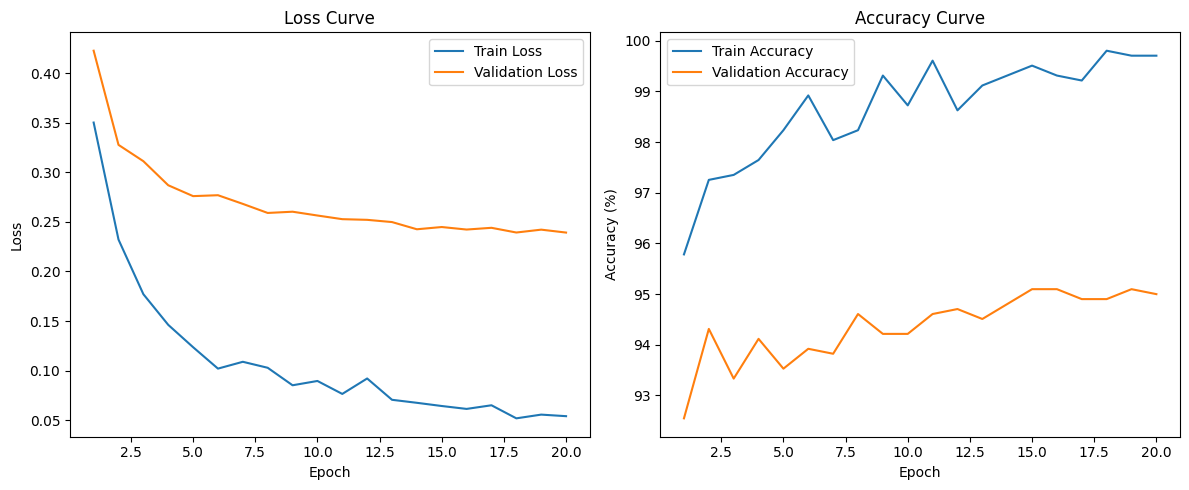

[0.35018898785778824, 0.2321454145892995, 0.17707196045722823, 0.1461610756984472, 0.12361334556500692, 0.10202566127552565, 0.10890901175166183, 0.10286857275051377, 0.08522741974368414, 0.08956820145577098, 0.07649781684722999, 0.09207455539414167, 0.0705694881681167, 0.06754232070671526, 0.06431265248444881, 0.06138701186454276, 0.06505036994831265, 0.051875130263499096, 0.05563396470587852, 0.05406241430687665]
[95.7843137254902, 97.25490196078431, 97.3529411764706, 97.6470588235294, 98.23529411764706, 98.92156862745098, 98.03921568627452, 98.23529411764706, 99.31372549019608, 98.72549019607843, 99.6078431372549, 98.62745098039215, 99.11764705882354, 99.31372549019608, 99.50980392156863, 99.31372549019608, 99.2156862745098, 99.80392156862744, 99.70588235294117, 99.70588235294117]
[0.4226330890913257, 0.32767337561830223, 0.3112098000523482, 0.28694296302887845, 0.275983204548998, 0.27689902777461467, 0.26816174972429213, 0.2590131906890512, 0.26026574789581336, 0.2564300462609259, 

In [ ]:
from sklearn.metrics import top_k_accuracy_score

try:
    model.load_state_dict(torch.load(final_model_path))
    print(f'Loaded final model from {final_model_path}')
except Exception as e:
    print(f'Error loading the final model: {e}')

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_correct_top5 = 0

test_all_preds = []
test_all_labels = []
test_all_probs = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Testing")

    for test_inputs, test_labels, test_weights in test_bar:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_weights = test_weights.to(device)

        with autocast():
            test_outputs = model(test_inputs)
            test_loss_batch = criterion(test_outputs, test_labels, test_weights)

        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

        top5_probs, top5_predicted = torch.topk(test_outputs, 5, dim=1)
        test_correct_top5 += torch.sum(top5_predicted.eq(test_labels.view(-1, 1).expand_as(top5_predicted))).item()

        test_all_preds.extend(test_predicted.cpu().numpy())
        test_all_labels.extend(test_labels.cpu().numpy())

        test_all_probs.extend(torch.softmax(test_outputs, dim=1).cpu().numpy())

        current_accuracy = 100 * test_correct / test_total
        current_top5_accuracy = 100 * test_correct_top5 / test_total
        test_bar.set_postfix(loss=test_loss_batch.item(),
                             accuracy=f"{current_accuracy:.2f}%",
                             top5_accuracy=f"{current_top5_accuracy:.2f}%")

test_epoch_loss = test_loss / len(test_dataset)
test_epoch_acc = 100 * test_correct / test_total
test_epoch_top5_acc = 100 * test_correct_top5 / test_total

test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_precision = precision_score(test_all_labels, test_all_preds, average='macro')
test_recall = recall_score(test_all_labels, test_all_preds, average='macro')
test_f1 = f1_score(test_all_labels, test_all_preds, average='macro')

print('Test Loss: {:.4f}, Top-1 Accuracy: {:.2f}%, Top-5 Accuracy: {:.2f}%'.format(
    test_epoch_loss, test_epoch_acc, test_epoch_top5_acc))
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)